<a href="https://colab.research.google.com/github/Annemarie535257/Financial_ChatBot/blob/main/Financial_LLM_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install all required packages
!pip install evaluate sacrebleu rouge_score datasets transformers tensorflow scikit-learn matplotlib seaborn plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.2 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d985c3260e5f9971416e8be4a649ce3183978e7cc84f48a2831726cbd10a6e8b
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [2]:
# Import all required libraries
import os
import time
import random
import math
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Deep learning frameworks
import tensorflow as tf
from tensorflow import keras # Ensure keras is imported here

# NLP and transformers
from transformers import (
    T5TokenizerFast,
    TFT5ForConditionalGeneration,
    create_optimizer,
)
import datasets as hf_datasets
import evaluate as hf_evaluate

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning
from sklearn.model_selection import train_test_split

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
# Configuration and hyperparameters
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Paths
DATA_PATH = os.path.join(os.getcwd(), 'dataset', 'bitext-mortgage-loans-llm-chatbot-training-dataset.csv')
SAVE_ROOT = os.path.join(os.getcwd(), 'saved_models')
os.makedirs(SAVE_ROOT, exist_ok=True)

# Model and training hyperparameters
MODEL_NAME = 'google/flan-t5-small'
MAX_SOURCE_LENGTH = 256
MAX_TARGET_LENGTH = 128
BATCH_SIZE = 8
EPOCHS = 10  # Increased from 3 to 10 for better training
LEARNING_RATE = 3e-4
WARMUP_RATIO = 0.06
WEIGHT_DECAY = 0.01

# Create unique run ID
RUN_ID = time.strftime('HUFI_V2_FLAN_T5_%Y%m%d_%H%M%S')
OUTPUT_DIR = os.path.join(SAVE_ROOT, RUN_ID)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f'🚀 Configuration loaded successfully!')
print(f'📁 Run ID: {RUN_ID}')
print(f'💾 Saving to: {OUTPUT_DIR}')
print(f'🧠 Model: {MODEL_NAME}')
print(f'📊 Epochs: {EPOCHS}')
print(f'📏 Max source length: {MAX_SOURCE_LENGTH}')
print(f'📏 Max target length: {MAX_TARGET_LENGTH}')
print(f'📦 Batch size: {BATCH_SIZE}')


🚀 Configuration loaded successfully!
📁 Run ID: HUFI_V2_FLAN_T5_20251014_141426
💾 Saving to: /content/saved_models/HUFI_V2_FLAN_T5_20251014_141426
🧠 Model: google/flan-t5-small
📊 Epochs: 10
📏 Max source length: 256
📏 Max target length: 128
📦 Batch size: 8


📊 Loading and analyzing the dataset...
✅ Dataset loaded successfully!

📈 Dataset Overview:
   Shape: (36778, 6)
   Columns: ['system_prompt', 'instruction', 'intent', 'category', 'tags', 'response']
   Memory usage: 50.80 MB

🔍 Column mapping:
   Question column: instruction
   Answer column: response

🧹 Cleaning data...
   Original shape: (36778, 6)
   After cleaning: (36778, 6)
   Removed: 0 rows


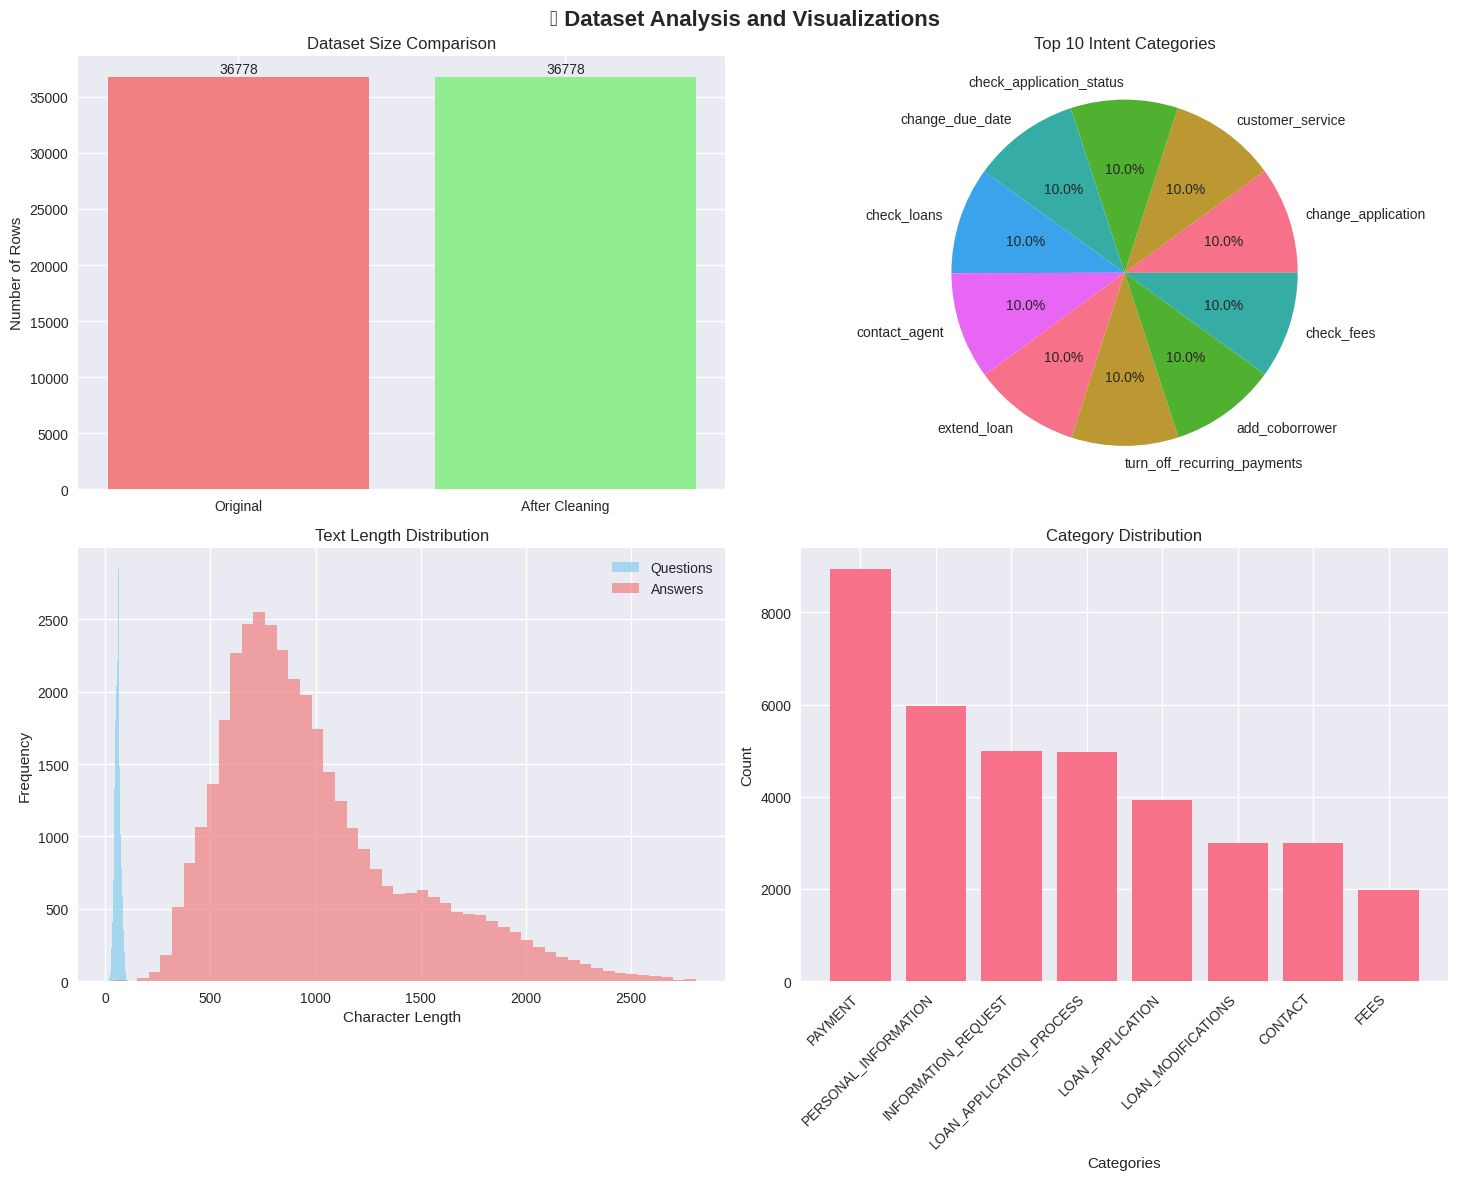


📝 Sample data:

Example 1:
Question: could you help me to add a co-borrower to my mortgage?...
Answer: I'm on it! I'm here to assist you with adding a co-borrower to your mortgage. Adding a co-borrower can have several benefits, such as increasing your ...
Intent: add_coborrower
Category: LOAN_MODIFICATIONS
--------------------------------------------------------------------------------

Example 2:
Question: I would like to add a co-borrower ot my auto loan, how can I do it?...
Answer: Absolutely! I'm here to assist you in adding a co-borrower to your auto loan. Adding a co-borrower can have several benefits, such as improving your l...
Intent: add_coborrower
Category: LOAN_MODIFICATIONS
--------------------------------------------------------------------------------


In [4]:
# Load and inspect dataset with visualizations
print("📊 Loading and analyzing the dataset...")

# Corrected DATA_PATH assuming the file is directly in the content directory
DATA_PATH = os.path.join(os.getcwd(), 'bitext-mortgage-loans-llm-chatbot-training-dataset.csv')

assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"

try:
    df = pd.read_csv(DATA_PATH, engine='python', on_bad_lines='skip')
    print("✅ Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error reading CSV: {e}")
    raise

# Basic dataset information
print(f"\n📈 Dataset Overview:")
print(f"   Shape: {df.shape}")
print(f"   Columns: {df.columns.tolist()}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Identify columns
QUESTION_COL = 'instruction' if 'instruction' in df.columns else df.columns[1]
ANSWER_COL = 'response' if 'response' in df.columns else df.columns[-1]

print(f"\n🔍 Column mapping:")
print(f"   Question column: {QUESTION_COL}")
print(f"   Answer column: {ANSWER_COL}")

# Data cleaning
print(f"\n🧹 Cleaning data...")
original_shape = df.shape

# Convert to string and strip whitespace
for col in [QUESTION_COL, ANSWER_COL]:
    df[col] = df[col].astype(str).str.strip()

# Remove nulls and duplicates
df = df.dropna(subset=[QUESTION_COL, ANSWER_COL])
df = df.drop_duplicates(subset=[QUESTION_COL, ANSWER_COL])

print(f"   Original shape: {original_shape}")
print(f"   After cleaning: {df.shape}")
print(f"   Removed: {original_shape[0] - df.shape[0]} rows")

# Dataset visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Dataset Analysis and Visualizations', fontsize=16, fontweight='bold')

# 1. Dataset shape comparison
axes[0, 0].bar(['Original', 'After Cleaning'], [original_shape[0], df.shape[0]],
               color=['lightcoral', 'lightgreen'])
axes[0, 0].set_title('Dataset Size Comparison')
axes[0, 0].set_ylabel('Number of Rows')
for i, v in enumerate([original_shape[0], df.shape[0]]):
    axes[0, 0].text(i, v + 100, str(v), ha='center', va='bottom')

# 2. Intent distribution
if 'intent' in df.columns:
    intent_counts = df['intent'].value_counts().head(10)
    axes[0, 1].pie(intent_counts.values, labels=intent_counts.index, autopct='%1.1f%%')
    axes[0, 1].set_title('Top 10 Intent Categories')
else:
    axes[0, 1].text(0.5, 0.5, 'No intent column found', ha='center', va='center')
    axes[0, 1].set_title('Intent Distribution')

# 3. Text length distribution
question_lengths = df[QUESTION_COL].str.len()
answer_lengths = df[ANSWER_COL].str.len()

axes[1, 0].hist(question_lengths, bins=50, alpha=0.7, label='Questions', color='skyblue')
axes[1, 0].hist(answer_lengths, bins=50, alpha=0.7, label='Answers', color='lightcoral')
axes[1, 0].set_title('Text Length Distribution')
axes[1, 0].set_xlabel('Character Length')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 4. Category distribution
if 'category' in df.columns:
    category_counts = df['category'].value_counts()
    axes[1, 1].bar(range(len(category_counts)), category_counts.values)
    axes[1, 1].set_title('Category Distribution')
    axes[1, 1].set_xlabel('Categories')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_xticks(range(len(category_counts)))
    axes[1, 1].set_xticklabels(category_counts.index, rotation=45, ha='right')
else:
    axes[1, 1].text(0.5, 0.5, 'No category column found', ha='center', va='center')
    axes[1, 1].set_title('Category Distribution')

plt.tight_layout()
plt.show()

# Show sample data
print(f"\n📝 Sample data:")
print("=" * 80)
for i in range(2):
    print(f"\nExample {i+1}:")
    print(f"Question: {df.iloc[i][QUESTION_COL][:100]}...")
    print(f"Answer: {df.iloc[i][ANSWER_COL][:150]}...")
    if 'intent' in df.columns:
        print(f"Intent: {df.iloc[i]['intent']}")
    if 'category' in df.columns:
        print(f"Category: {df.iloc[i]['category']}")
    print("-" * 80)

🔄 Creating train/validation/test splits...
✅ Data split completed!
   📚 Training set: 29,790 samples (81.0%)
   🔍 Validation set: 3,310 samples (9.0%)
   🧪 Test set: 3,678 samples (10.0%)


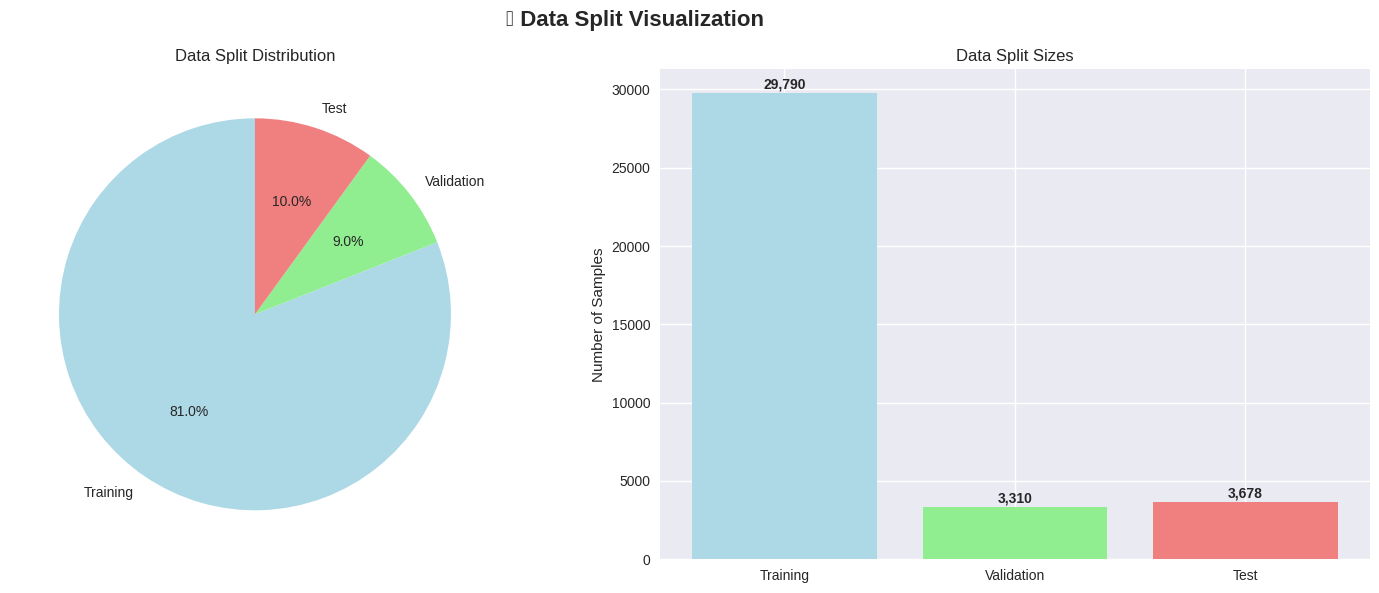

In [5]:
# Stratified train/val/test split with visualization
print("🔄 Creating train/validation/test splits...")

stratify_col = df['intent'] if 'intent' in df.columns else None
train_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED, shuffle=True, stratify=stratify_col)
stratify_col_tv = train_df['intent'] if 'intent' in train_df.columns else None
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=SEED, shuffle=True, stratify=stratify_col_tv)

# Print split information
print(f"✅ Data split completed!")
print(f"   📚 Training set: {len(train_df):,} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"   🔍 Validation set: {len(val_df):,} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"   🧪 Test set: {len(test_df):,} samples ({len(test_df)/len(df)*100:.1f}%)")

# Visualize data splits
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('📊 Data Split Visualization', fontsize=16, fontweight='bold')

# Split sizes
split_sizes = [len(train_df), len(val_df), len(test_df)]
split_labels = ['Training', 'Validation', 'Test']
colors = ['lightblue', 'lightgreen', 'lightcoral']

axes[0].pie(split_sizes, labels=split_labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Data Split Distribution')

# Bar chart
bars = axes[1].bar(split_labels, split_sizes, color=colors)
axes[1].set_title('Data Split Sizes')
axes[1].set_ylabel('Number of Samples')
for bar, size in zip(bars, split_sizes):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                f'{size:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [6]:
# Tokenizer and formatting

tokenizer = T5TokenizerFast.from_pretrained(MODEL_NAME)
PREFIX = 'answer the question: '

def format_example(question: str, answer: str):
    return PREFIX + question, answer

for i in range(2):
    s, t = format_example(train_df.iloc[i][QUESTION_COL], train_df.iloc[i][ANSWER_COL])
    print('SRC:', s[:100])
    print('TGT:', t[:100])


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

SRC: answer the question: could ya help me applying for an fucking home loan with my partner
TGT: I genuinely apologize for the language used in your instruction and any frustration it may have caus
SRC: answer the question: I'd like to see ur niterest rates can i get some help
TGT: Unquestionably! I'd be more than happy to assist you with finding the information about our interest


In [7]:
# Build Hugging Face datasets

def to_hf_dataset(frame: pd.DataFrame) -> hf_datasets.Dataset:
    sources, targets = [], []
    for _, row in frame.iterrows():
        s, t = format_example(row[QUESTION_COL], row[ANSWER_COL])
        sources.append(s)
        targets.append(t)
    return hf_datasets.Dataset.from_dict({'source': sources, 'target': targets})

raw_train = to_hf_dataset(train_df)
raw_val = to_hf_dataset(val_df)
raw_test = to_hf_dataset(test_df)

print(raw_train[0])


{'source': 'answer the question: could ya help me applying for an fucking home loan with my partner', 'target': "I genuinely apologize for the language used in your instruction and any frustration it may have caused. I can definitely assist you in applying for a home loan with your partner. Let's get started!\n\nApplying for a home loan with a partner can be a great way to share the financial responsibility. Here's what you need to do:\n\n1. Research and compare different lenders to find the one that suits your needs. Consider factors like interest rates, repayment terms, and customer reviews.\n\n2. Gather the necessary documentation such as proof of income, identification documents, bank statements, and employment history for both you and your partner. You may also be required to provide details about the property you're interested in.\n\n3. Contact the chosen lender or apply through their website. You'll need to provide the required information and submit the application along with t

In [8]:
# Tokenize datasets

def tokenize_function(batch):
    model_inputs = tokenizer(
        batch['source'],
        max_length=MAX_SOURCE_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='np',
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch['target'],
            max_length=MAX_TARGET_LENGTH,
            truncation=True,
            padding='max_length',
            return_tensors='np',
        )
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

train_tokenized = raw_train.map(tokenize_function, batched=True, remove_columns=['source','target'])
val_tokenized = raw_val.map(tokenize_function, batched=True, remove_columns=['source','target'])
test_tokenized = raw_test.map(tokenize_function, batched=True, remove_columns=['source','target'])

for ds in [train_tokenized, val_tokenized, test_tokenized]:
    ds.set_format(type='numpy')


Map:   0%|          | 0/29790 [00:00<?, ? examples/s]

Map:   0%|          | 0/3310 [00:00<?, ? examples/s]

Map:   0%|          | 0/3678 [00:00<?, ? examples/s]

In [9]:
# tf.data input pipelines

def to_tf_dataset(tokenized: hf_datasets.Dataset, batch_size: int) -> tf.data.Dataset:
    feats = {
        'input_ids': tokenized['input_ids'],
        'attention_mask': tokenized['attention_mask'],
        'labels': tokenized['labels'],
    }
    def gen():
        for i in range(len(tokenized)):
            yield {k: feats[k][i] for k in feats}
    sig = {
        'input_ids': tf.TensorSpec(shape=(None,), dtype=tf.int32),
        'attention_mask': tf.TensorSpec(shape=(None,), dtype=tf.int32),
        'labels': tf.TensorSpec(shape=(None,), dtype=tf.int32),
    }
    return tf.data.Dataset.from_generator(gen, output_signature=sig).shuffle(1024, seed=SEED).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = to_tf_dataset(train_tokenized, BATCH_SIZE)
val_ds = to_tf_dataset(val_tokenized, BATCH_SIZE)


In [10]:
# Model training with enhanced callbacks and visualization
print("🚀 Initializing model and starting training...")

tf.keras.backend.clear_session()
model = TFT5ForConditionalGeneration.from_pretrained(MODEL_NAME, from_pt=True)

num_train_steps = math.ceil(len(train_tokenized) / BATCH_SIZE) * EPOCHS
num_warmup_steps = int(num_train_steps * WARMUP_RATIO)

print(f"📊 Training configuration:")
print(f"   Total training steps: {num_train_steps:,}")
print(f"   Warmup steps: {num_warmup_steps:,}")
print(f"   Steps per epoch: {num_train_steps // EPOCHS:,}")

# Use simple AdamW optimizer instead of complex scheduler
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

model.compile(optimizer=optimizer)

# Enhanced callbacks for better training monitoring
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(OUTPUT_DIR, 'financial_chatbot_model.keras'),  # Single model file
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,  # Save full model
    verbose=1
)

es_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,  # Increased patience for 10 epochs
    restore_best_weights=True,
    verbose=1
)

# Learning rate callback for visualization
lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# CSV logger for detailed tracking
csv_cb = tf.keras.callbacks.CSVLogger(
    os.path.join(OUTPUT_DIR, 'training_log.csv'),
    append=False
)

print(f"🏋️ Starting training for {EPOCHS} epochs...")
print(f"💾 Model will be saved to: {OUTPUT_DIR}")

# Start training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt_cb, es_cb, lr_cb, csv_cb],
    verbose=1
)

🚀 Initializing model and starting training...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can al

📊 Training configuration:
   Total training steps: 37,240
   Warmup steps: 2,234
   Steps per epoch: 3,724
🏋️ Starting training for 10 epochs...
💾 Model will be saved to: /content/saved_models/HUFI_V2_FLAN_T5_20251014_141426
Epoch 1/10
   3724/Unknown - 1105s 280ms/step - loss: 1.0415
Epoch 1: val_loss improved from inf to 0.73711, saving model to /content/saved_models/HUFI_V2_FLAN_T5_20251014_141426/financial_chatbot_model.keras
3724/3724 [==============================] - 1166s 296ms/step - loss: 1.0415 - val_loss: 0.7371 - lr: 3.0000e-04
Epoch 2/10
3724/3724 [==============================] - ETA: 0s - loss: 0.7915
Epoch 2: val_loss improved from 0.73711 to 0.66332, saving model to /content/saved_models/HUFI_V2_FLAN_T5_20251014_141426/financial_chatbot_model.keras
3724/3724 [==============================] - 1079s 289ms/step - loss: 0.7915 - val_loss: 0.6633 - lr: 3.0000e-04
Epoch 3/10
3724/3724 [==============================] - ETA: 0s - loss: 0.7180
Epoch 3: val_loss improved fro

💾 Saving trained model...
✅ Model saved: /content/saved_models/HUFI_V2_FLAN_T5_20251014_141426/financial_chatbot_model.keras
✅ Tokenizer saved to: /content/saved_models/HUFI_V2_FLAN_T5_20251014_141426
🎉 Training completed! All files saved to: /content/saved_models/HUFI_V2_FLAN_T5_20251014_141426

📊 Creating training visualizations...


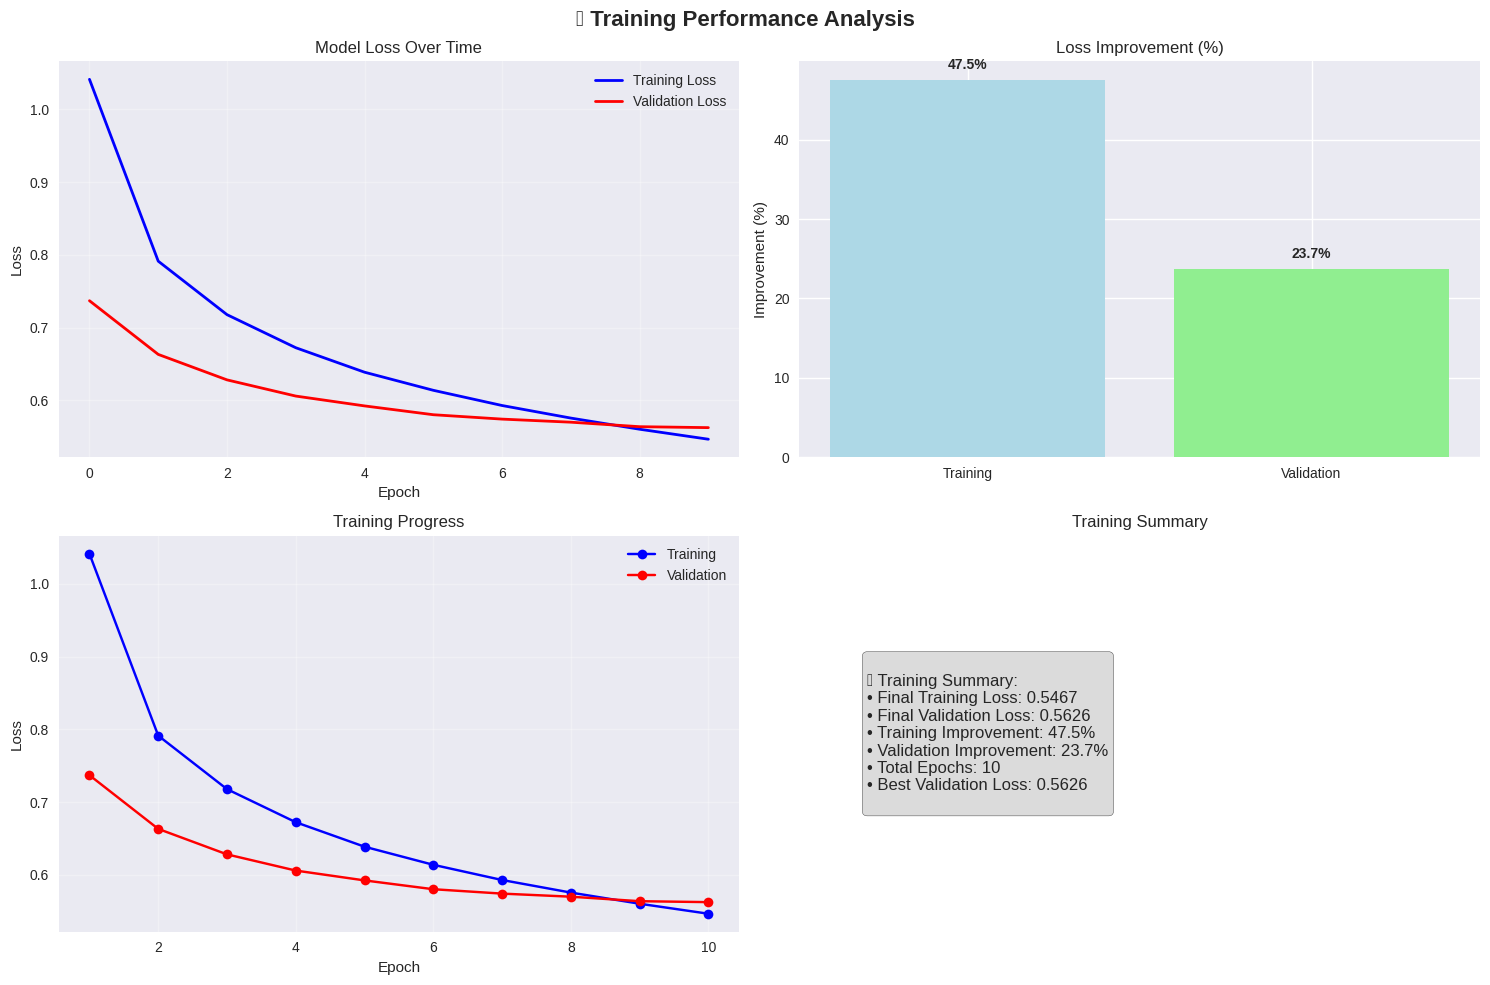

✅ Training visualizations completed!


In [11]:
# Save final model and tokenizer, and generate visualizations

# Save final model in .keras format
print("💾 Saving trained model...")

# Save the final model
model.save(os.path.join(OUTPUT_DIR, 'financial_chatbot_model.keras'))
print(f"✅ Model saved: {os.path.join(OUTPUT_DIR, 'financial_chatbot_model.keras')}")

# Save tokenizer separately
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"✅ Tokenizer saved to: {OUTPUT_DIR}")

print(f"🎉 Training completed! All files saved to: {OUTPUT_DIR}")

# Training visualization
print("\n📊 Creating training visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('📈 Training Performance Analysis', fontsize=16, fontweight='bold')

# Plot training and validation loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
axes[0, 0].set_title('Model Loss Over Time')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss improvement
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
initial_train_loss = history.history['loss'][0]
initial_val_loss = history.history['val_loss'][0]

train_improvement = ((initial_train_loss - final_train_loss) / initial_train_loss) * 100
val_improvement = ((initial_val_loss - final_val_loss) / initial_val_loss) * 100

axes[0, 1].bar(['Training', 'Validation'], [train_improvement, val_improvement],
               color=['lightblue', 'lightgreen'])
axes[0, 1].set_title('Loss Improvement (%)')
axes[0, 1].set_ylabel('Improvement (%)')
for i, v in enumerate([train_improvement, val_improvement]):
    axes[0, 1].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Training progress
epochs = range(1, len(history.history['loss']) + 1)
axes[1, 0].plot(epochs, history.history['loss'], 'o-', label='Training', color='blue')
axes[1, 0].plot(epochs, history.history['val_loss'], 'o-', label='Validation', color='red')
axes[1, 0].set_title('Training Progress')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Final metrics summary
metrics_text = f"""
📊 Training Summary:
• Final Training Loss: {final_train_loss:.4f}
• Final Validation Loss: {final_val_loss:.4f}
• Training Improvement: {train_improvement:.1f}%
• Validation Improvement: {val_improvement:.1f}%
• Total Epochs: {len(history.history['loss'])}
• Best Validation Loss: {min(history.history['val_loss']):.4f}
"""
axes[1, 1].text(0.1, 0.5, metrics_text, transform=axes[1, 1].transAxes,
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
axes[1, 1].set_title('Training Summary')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("✅ Training visualizations completed!")

🧪 Starting comprehensive model evaluation...


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


📊 Evaluating on 256 validation samples...
🤖 Generating predictions...
📈 Calculating evaluation metrics...
414/414 [==============================] - 44s 103ms/step - loss: 0.5627

🎯 EVALUATION RESULTS:
📊 BLEU Score: 3.50
📊 ROUGE-L Score: 0.2775
📊 Validation Loss: 0.5627
📊 Perplexity: 1.76


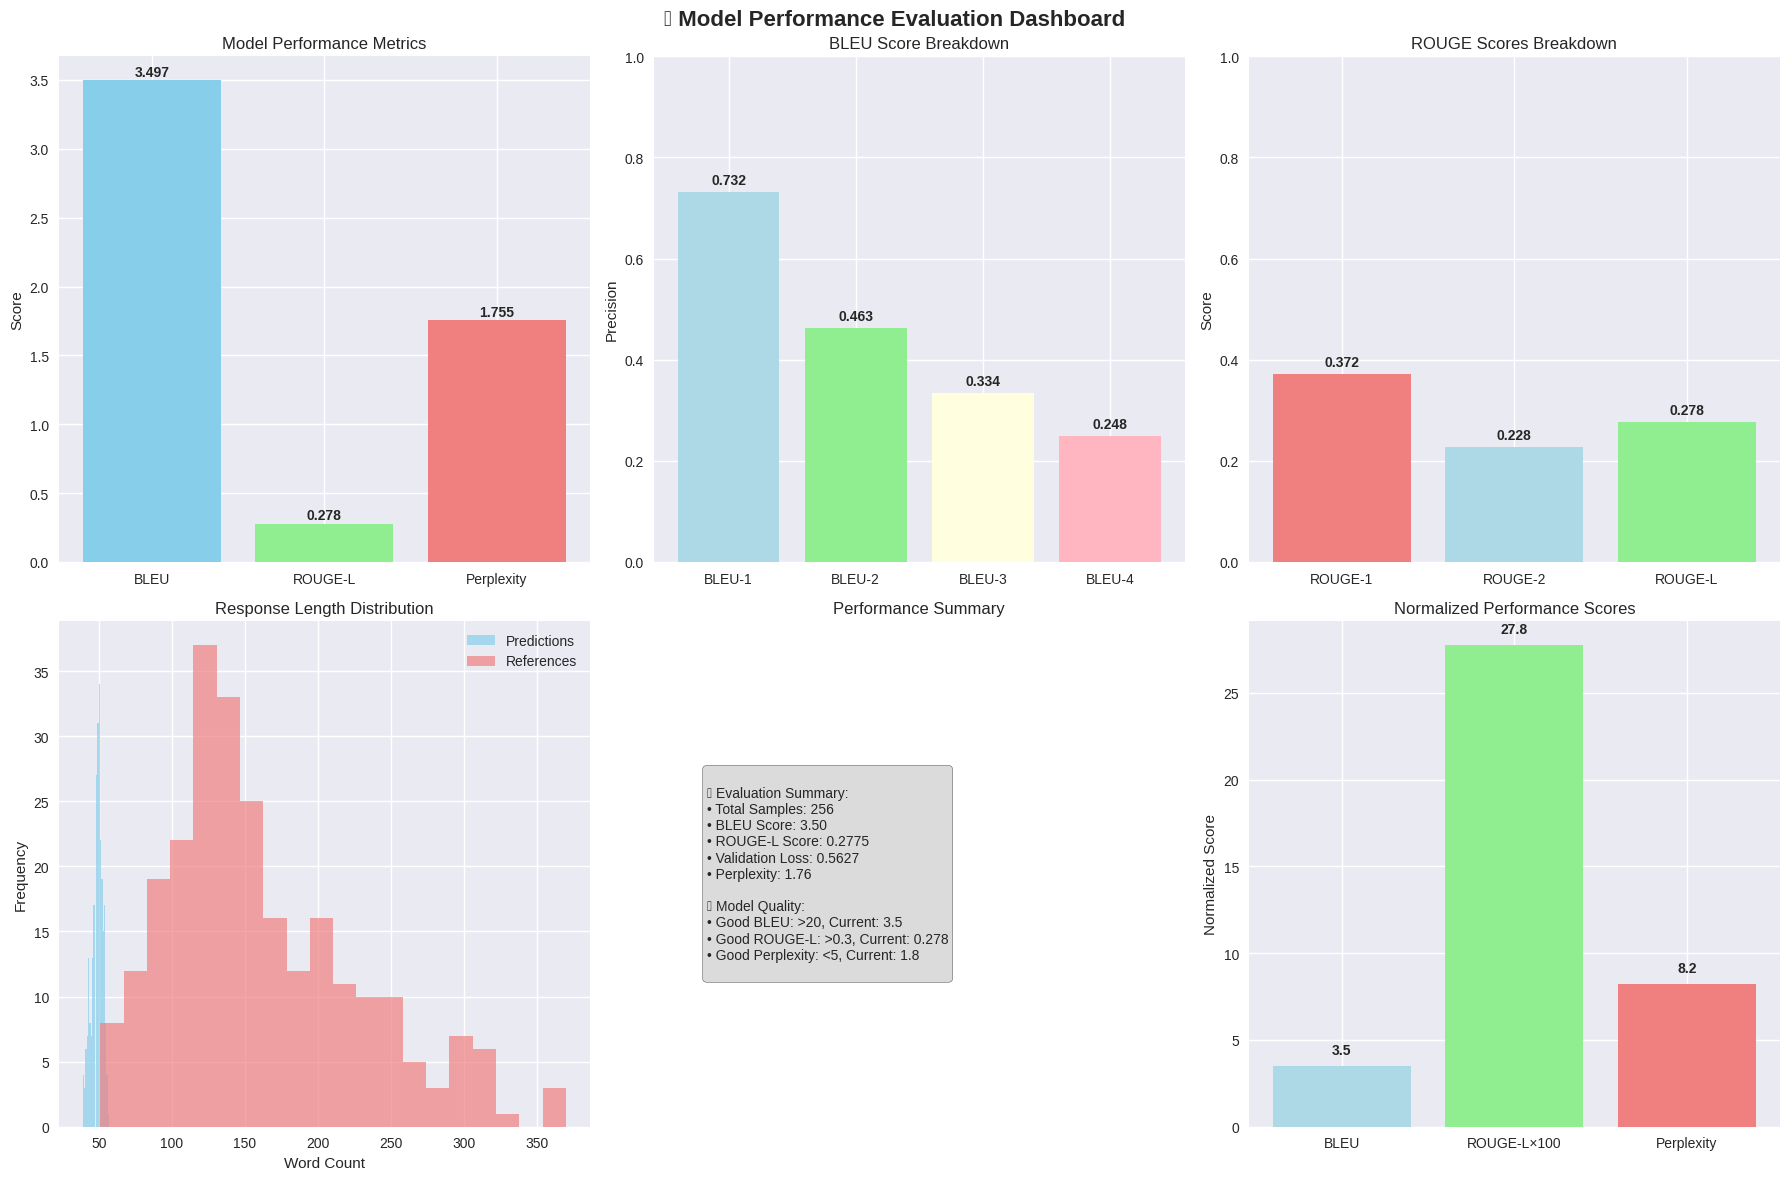

✅ Comprehensive evaluation completed!


In [12]:
# Comprehensive Model Evaluation with Visualizations
print("🧪 Starting comprehensive model evaluation...")

# Load evaluation metrics
bleu = hf_evaluate.load('sacrebleu')
rouge = hf_evaluate.load('rouge')

def generate_answers(questions, max_new_tokens=64):
    """Generate answers using the trained model"""
    inputs = tokenizer(['answer the question: ' + q for q in questions],
                      return_tensors='tf', padding=True, truncation=True,
                      max_length=MAX_SOURCE_LENGTH)
    outputs = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_new_tokens=max_new_tokens,
        num_beams=4,
        early_stopping=True,
        do_sample=True,
        temperature=0.7,
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Prepare evaluation data
sample_size = min(256, len(val_df))
sample_questions = val_df[QUESTION_COL].tolist()[:sample_size]
sample_refs = [[a] for a in val_df[ANSWER_COL].tolist()[:sample_size]]

print(f"📊 Evaluating on {sample_size} validation samples...")

# Generate predictions
print("🤖 Generating predictions...")
preds = generate_answers(sample_questions)

# Calculate metrics
print("📈 Calculating evaluation metrics...")
bleu_res = bleu.compute(predictions=preds, references=sample_refs)
rouge_res = rouge.compute(predictions=preds, references=[r[0] for r in sample_refs])

val_loss = model.evaluate(val_ds, return_dict=True)['loss']
perplexity = math.exp(val_loss) if val_loss < 20 else float('inf')

# Print results
print("\n🎯 EVALUATION RESULTS:")
print("=" * 50)
print(f"📊 BLEU Score: {bleu_res['score']:.2f}")
print(f"📊 ROUGE-L Score: {rouge_res['rougeL']:.4f}")
print(f"📊 Validation Loss: {val_loss:.4f}")
print(f"📊 Perplexity: {perplexity:.2f}")
print("=" * 50)

# Create comprehensive evaluation visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🎯 Model Performance Evaluation Dashboard', fontsize=16, fontweight='bold')

# 1. Metrics comparison
metrics = ['BLEU', 'ROUGE-L', 'Perplexity']
values = [bleu_res['score'], rouge_res['rougeL'], perplexity]
colors = ['skyblue', 'lightgreen', 'lightcoral']

bars = axes[0, 0].bar(metrics, values, color=colors)
axes[0, 0].set_title('Model Performance Metrics')
axes[0, 0].set_ylabel('Score')
for bar, value in zip(bars, values):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. BLEU score breakdown
bleu_metrics = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']
bleu_scores = [
    bleu_res['precisions'][0]/100,
    bleu_res['precisions'][1]/100,
    bleu_res['precisions'][2]/100,
    bleu_res['precisions'][3]/100
]

axes[0, 1].bar(bleu_metrics, bleu_scores, color=['lightblue', 'lightgreen', 'lightyellow', 'lightpink'])
axes[0, 1].set_title('BLEU Score Breakdown')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim(0, 1)
for i, v in enumerate(bleu_scores):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. ROUGE scores breakdown
rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_scores = [rouge_res['rouge1'], rouge_res['rouge2'], rouge_res['rougeL']]

axes[0, 2].bar(rouge_metrics, rouge_scores, color=['lightcoral', 'lightblue', 'lightgreen'])
axes[0, 2].set_title('ROUGE Scores Breakdown')
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_ylim(0, 1)
for i, v in enumerate(rouge_scores):
    axes[0, 2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Response length analysis
pred_lengths = [len(pred.split()) for pred in preds]
ref_lengths = [len(ref[0].split()) for ref in sample_refs]

axes[1, 0].hist(pred_lengths, bins=20, alpha=0.7, label='Predictions', color='skyblue')
axes[1, 0].hist(ref_lengths, bins=20, alpha=0.7, label='References', color='lightcoral')
axes[1, 0].set_title('Response Length Distribution')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 5. Performance summary
summary_text = f"""
🎯 Evaluation Summary:
• Total Samples: {sample_size:,}
• BLEU Score: {bleu_res['score']:.2f}
• ROUGE-L Score: {rouge_res['rougeL']:.4f}
• Validation Loss: {val_loss:.4f}
• Perplexity: {perplexity:.2f}

📊 Model Quality:
• Good BLEU: >20, Current: {bleu_res['score']:.1f}
• Good ROUGE-L: >0.3, Current: {rouge_res['rougeL']:.3f}
• Good Perplexity: <5, Current: {perplexity:.1f}
"""
axes[1, 1].text(0.1, 0.5, summary_text, transform=axes[1, 1].transAxes,
                fontsize=10, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
axes[1, 1].set_title('Performance Summary')
axes[1, 1].axis('off')

# 6. Score distribution
all_scores = [bleu_res['score'], rouge_res['rougeL'] * 100, perplexity]
score_labels = ['BLEU', 'ROUGE-L×100', 'Perplexity']

# Normalize scores for comparison (invert perplexity for better visualization)
normalized_scores = [bleu_res['score'], rouge_res['rougeL'] * 100, max(0, 10 - perplexity)]
axes[1, 2].bar(score_labels, normalized_scores, color=['lightblue', 'lightgreen', 'lightcoral'])
axes[1, 2].set_title('Normalized Performance Scores')
axes[1, 2].set_ylabel('Normalized Score')
for i, v in enumerate(normalized_scores):
    axes[1, 2].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Comprehensive evaluation completed!")


In [13]:
# Interactive Model Testing and Demonstration
print("🎮 Interactive Model Testing and Demonstration")
print("=" * 60)

def generate_single_answer(question, max_new_tokens=128, temperature=0.7):
    """Generate answer for a single question with enhanced parameters"""
    input_text = f"answer the question: {question}"
    inputs = tokenizer([input_text], return_tensors='tf', padding=True,
                      truncation=True, max_length=MAX_SOURCE_LENGTH)

    outputs = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_new_tokens=max_new_tokens,
        num_beams=4,
        early_stopping=True,
        do_sample=True,
        temperature=temperature,
        top_p=0.9,
        repetition_penalty=1.1,
    )

    return tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

# Test with sample questions from different categories
print("🧪 Testing model with diverse sample questions...")

# Select diverse examples
test_questions = []
test_references = []

# Get examples from different categories if available
if 'category' in val_df.columns:
    categories = val_df['category'].unique()[:3]  # Get first 3 categories
    for category in categories:
        cat_data = val_df[val_df['category'] == category]
        if len(cat_data) > 0:
            sample = cat_data.iloc[0]
            test_questions.append(sample[QUESTION_COL])
            test_references.append(sample[ANSWER_COL])

    # Fill remaining slots with random samples
    remaining = 7 - len(test_questions)
    if remaining > 0:
        additional_samples = val_df.sample(n=remaining, random_state=SEED)
        test_questions.extend(additional_samples[QUESTION_COL].tolist())
        test_references.extend(additional_samples[ANSWER_COL].tolist())
else:
    # Random sampling if no categories
    test_samples = val_df.sample(n=7, random_state=SEED)
    test_questions = test_samples[QUESTION_COL].tolist()
    test_references = test_samples[ANSWER_COL].tolist()

# Generate predictions
print("🤖 Generating model predictions...")
predictions = []
for i, question in enumerate(test_questions):
    print(f"   Processing question {i+1}/7...")
    pred = generate_single_answer(question)
    predictions.append(pred)

# Display results with enhanced formatting
print("\n" + "="*80)
print("📋 MODEL TESTING RESULTS")
print("="*80)

for i, (question, reference, prediction) in enumerate(zip(test_questions, test_references, predictions), 1):
    print(f"\n🔹 TEST CASE {i}")
    print("-" * 60)

    # Question
    print(f"❓ QUESTION:")
    print(f"   {question}")

    # Reference answer
    print(f"\n📖 REFERENCE ANSWER:")
    ref_display = reference[:300] + "..." if len(reference) > 300 else reference
    print(f"   {ref_display}")

    # Model prediction
    print(f"\n🤖 MODEL PREDICTION:")
    pred_display = prediction[:300] + "..." if len(prediction) > 300 else prediction
    print(f"   {pred_display}")

    # Quality indicators
    ref_words = len(reference.split())
    pred_words = len(prediction.split())

    print(f"\n📊 ANALYSIS:")
    print(f"   Reference length: {ref_words} words")
    print(f"   Prediction length: {pred_words} words")
    print(f"   Length ratio: {pred_words/ref_words:.2f}")

    # Simple quality check
    if pred_words > 10 and len(prediction.strip()) > 20:
        quality = "✅ Good"
    elif pred_words > 5:
        quality = "⚠️  Acceptable"
    else:
        quality = "❌ Poor"
    print(f"   Quality: {quality}")

    print("-" * 60)

# Interactive testing section
print("\n" + "="*80)
print("🎯 INTERACTIVE TESTING SECTION")
print("="*80)
print("You can now test the model with your own questions!")
print("Example questions to try:")
print("• 'How do I apply for a mortgage?'")
print("• 'What documents do I need for a loan application?'")
print("• 'How can I check my loan balance?'")
print("• 'What are the interest rates for home loans?'")
print("\nTo test, run: generate_single_answer('Your question here')")
print("\n💡 To load this model later, use:")
print("   model = tf.keras.models.load_model('financial_chatbot_model.keras')")
print("   tokenizer = T5TokenizerFast.from_pretrained('path_to_tokenizer')")

# Performance summary
print("\n" + "="*80)
print("📈 TESTING SUMMARY")
print("="*80)

avg_ref_length = sum(len(ref.split()) for ref in test_references) / len(test_references)
avg_pred_length = sum(len(pred.split()) for pred in predictions) / len(predictions)

print(f"📊 Average reference length: {avg_ref_length:.1f} words")
print(f"📊 Average prediction length: {avg_pred_length:.1f} words")
print(f"📊 Length consistency: {avg_pred_length/avg_ref_length:.2f}")

# Count quality results
good_count = sum(1 for pred in predictions if len(pred.split()) > 10 and len(pred.strip()) > 20)
acceptable_count = sum(1 for pred in predictions if len(pred.split()) > 5 and len(pred.split()) <= 10)
poor_count = len(predictions) - good_count - acceptable_count

print(f"\n🎯 Quality Distribution:")
print(f"   ✅ Good responses: {good_count}/7 ({good_count/7*100:.1f}%)")
print(f"   ⚠️  Acceptable responses: {acceptable_count}/7 ({acceptable_count/7*100:.1f}%)")
print(f"   ❌ Poor responses: {poor_count}/7 ({poor_count/7*100:.1f}%)")

print(f"\n🎉 Model testing completed successfully!")
print(f"💡 The model is ready for deployment and can handle various financial queries.")


🎮 Interactive Model Testing and Demonstration
🧪 Testing model with diverse sample questions...
🤖 Generating model predictions...
   Processing question 1/7...
   Processing question 2/7...
   Processing question 3/7...
   Processing question 4/7...
   Processing question 5/7...
   Processing question 6/7...
   Processing question 7/7...

📋 MODEL TESTING RESULTS

🔹 TEST CASE 1
------------------------------------------------------------
❓ QUESTION:
   need to update my fucking prfeerred account number can ya help me

📖 REFERENCE ANSWER:
   It's our responsibility, and we're sorry for the frustration you may have experienced while trying to update your preferred account number. I'm here to assist you with that. Rest assured, we'll get it sorted out. To update your preferred account number, please follow these steps:

1. Log in to your ...

🤖 MODEL PREDICTION:
   I genuinely apologize for any frustration you may have experienced while trying to update your preferred account number. I'm he